In [9]:
import networkx as nx
import pprint
import matplotlib.pyplot as plt
import random
import numpy as np
from sklearn.manifold import TSNE
import torch
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from gensim.models import Word2Vec as word2vec
from collections import OrderedDict

In [10]:
# 計算機の台数
N = 4
# 交流行列の成分の取る値の範囲
range_min, range_max = 1, 100 # 乱数の範囲

# 計算機の担当するニューロンを格納するdictを作成
nodes = OrderedDict()
for i in range(N):
    nodes["計算機" + str(i)] = []

# print(nodes)


# 乱数で対称な交流行列を生成
comm_matrix = [[0.0 for _ in range(N)] for _ in range(N)]
for i in range(N):
    for j in range(i, N):
        if i == j:
            comm_matrix[i][j] = 0
        else:
            comm_matrix[i][j] = int(random.uniform(range_min, range_max))
            comm_matrix[j][i] = comm_matrix[i][j]
comm_matrix = np.array(comm_matrix)
pprint.pprint(comm_matrix)

array([[ 0,  8, 26, 22],
       [ 8,  0, 74, 59],
       [26, 74,  0, 46],
       [22, 59, 46,  0]])


'{1: [2, 3, 4], 2: [1, 3, 4], 3: [1, 2, 4], 4: [1, 2, 3]}'


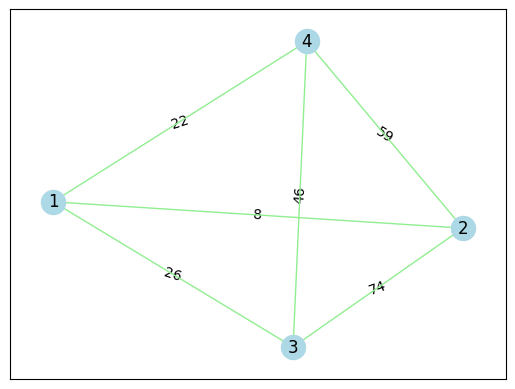

In [11]:
G = nx.Graph() # 無向グラフ

node_list = list(range(N))
#ノードのラベルを1からNにする
node_list = [node+1 for node in node_list]

# nodeデータの追加
G.add_nodes_from(node_list)

# edgeの追加
# 重み（通信コスト）をcomm_matrix(交流行列)より取得し
for i in range(1, N):
    for j in range(1, N):
        if i != j+1:
            G.add_edge(i, j+1, weight=comm_matrix[i-1][j])

# グラフから隣接リストを取得
adj_list = nx.to_dict_of_lists(G)
pprint.pprint(f'{adj_list}')

# グラフの描画
pos = nx.spring_layout(G)
edge_labels = {(u, v): d['weight'] for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
nx.draw_networkx(G, pos, with_labels=True, node_color='lightblue', edge_color="lightgreen")

plt.show()

In [12]:
# 出発地ノードと目的地ノードを設定
start = 1
end = 4

# ダイクストラ法で最短経路とその重みを求める
shortest_path = nx.dijkstra_path(G, start, end)
shortest_path_weight = nx.dijkstra_path_length(G, start, end)

# 出力
print("Shortest Path:", shortest_path)
print("Weight:", shortest_path_weight)

Shortest Path: [1, 4]
Weight: 22


In [13]:
# 計算機ととニューロンを定義
pc = ["pc1", "pc2", "pc3", "pc4"]
neauron = ["n1", "n2", "n3", "n4", "n5", "n6", "n7", "n8", "n9", "n10", "n11", "n12"]

# 各人に3つのタスクをランダムに割り当てる
assignments = {person: random.sample(neauron, 3) for person in pc}

# 割り当て結果を表示
pprint.pprint(assignments)

{'pc1': ['n11', 'n8', 'n10'],
 'pc2': ['n9', 'n3', 'n4'],
 'pc3': ['n6', 'n10', 'n1'],
 'pc4': ['n6', 'n8', 'n9']}
